# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [3]:
portfolio.sample(10)

,reward,channels,difficulty,duration,offer_type,id
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
portfolio['offer_type'].value_counts()


bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [5]:
portfolio[['difficulty' , 'offer_type']][portfolio.offer_type=='informational']
#it seems that informational offer type =  0 difficulty

,difficulty,offer_type
2,0,informational
7,0,informational


In [6]:
profile.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
profile.sample(10)

,gender,age,id,became_member_on,income
7873,M,64,3a97e25f6f4c4bdca5507037f985b4f6,20180615,67000.0
15083,M,67,02f638a6c98241c98b24a06ca489aac0,20171207,46000.0
14585,F,67,76830f4119594aa79e6d7627d96e00fc,20171215,33000.0
11301,F,51,df9877d5bcbf440f8548776a6d7e8da2,20171106,49000.0
10147,F,59,831756172c1f4d7cb4f3cbc848aecd35,20170921,47000.0
15661,None,118,a44a954015e44908aaf220abdd1f65f2,20170810,NaN
4136,F,49,2202161defd14ab9a089cdc5e9c48f3c,20180122,45000.0
7356,M,19,89c440131f9347a1910d940e46cb4056,20180319,44000.0
4907,F,80,8f3d34f0adde4c659a1d8ab887637ba5,20171123,58000.0
14089,None,118,546d58ea43274df6875254b4201fd3a4,20160505,NaN


In [8]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [9]:
print(profile['age'].value_counts())
print(profile['income'].value_counts())

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64
73000.0     314
72000.0     297
71000.0     294
57000.0     288
74000.0     282
           ... 
116000.0     46
107000.0     45
112000.0     45
117000.0     32
120000.0     13
Name: income, Length: 91, dtype: int64


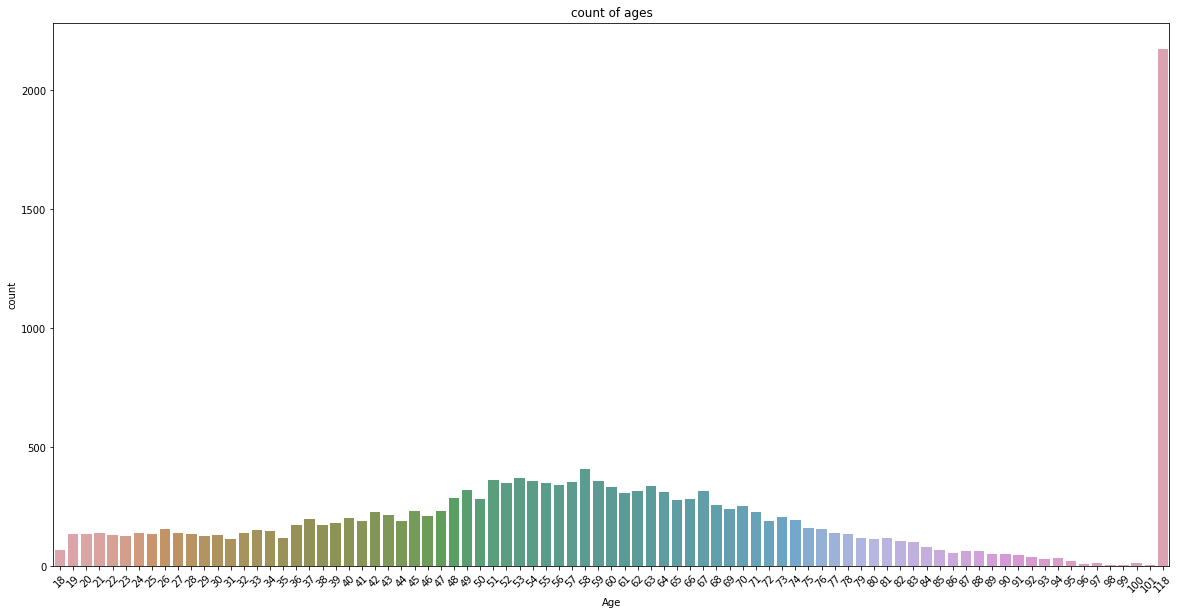

In [10]:
plt.figure(figsize=(20, 10))
sns.countplot(profile['age'], saturation=.5)
plt.title('count of ages')
plt.ylabel('count')
plt.xlabel('Age')
plt.xticks(rotation = 45)
plt.show();


In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [12]:
transcript.sample(10)

,person,event,value,time
67617,27877b28fd5743e6a8b828227e878113,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168
45091,3597f1f307134a28894afe960cae8f0b,transaction,{'amount': 1.26},114
251354,c4e840f6afb043a99781ce5a55cab241,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},576
231167,c7432bfcf7284c078b0fbaeaad0a019f,transaction,{'amount': 28.58},534
284000,09e73eeb14874fe69467f8c123091f50,transaction,{'amount': 4.5600000000000005},630
157592,d1a98d3953d8484286bf024fec8464b4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},408
228189,123ac69b408044deafb64369fcc85a67,transaction,{'amount': 0.2},528
139718,c9121c7664ca4e16b88cf81e8a964cf7,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,372
3896,8bf8695026e34614b64f99cc3ebabfea,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
163304,90596138fff840eea528be9100e00f09,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408


In [13]:
#checking the NaNs in each set
print('portfolio:\n',portfolio.isna().sum())
print('\nprofile:\n',profile.isna().sum())
print('\ntranscript:\n',transcript.isna().sum())

portfolio:
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

profile:
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

transcript:
 person    0
event     0
value     0
time      0
dtype: int64


In [14]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [15]:
profile_na = profile[profile['income'].isna()]


In [16]:
profile_na.head()


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN


In [17]:
profile_na['age'].value_counts()

118    2175
Name: age, dtype: int64

In [18]:
# convert the datatype into datetime
profile["became_member_on"] = pd.to_datetime(profile.became_member_on.apply(str))

# split the data after '-' in year column to year
profile['became_member_year'] = profile['became_member_on'].apply(lambda x: x.year)

#split the data after '-' in month column to month
profile['became_member_month'] = profile['became_member_on'].apply(lambda x: x.month)
profile = profile.drop('became_member_on', axis=1)

In [19]:
#it seems that the '118' value in the age column is a placeholder for NaN

In [20]:
#TO DO NEXT:
# 1.) split "channels" into three columns and encode it (0s and 1s)
# 2.) determine whether or not to drop/fill the NaNs, and how.
# 3.) extract the offer ID and the amount from the values column in transcript dataframe
# 4.) merge the datasets

In [21]:
#splitting the channels:

channels_values = set()
for channel in portfolio.channels:
    channels_values.update(set(channel))

In [22]:
channels_values

{'email', 'mobile', 'social', 'web'}

In [23]:
#channels into columns:
for i in channels_values:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
# [LATER] remove channels column    
# portfolio.drop('channels', axis = 1, inplace=True) 
portfolio.sample(10)

,reward,channels,difficulty,duration,offer_type,id,email,web,social,mobile
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,0,1,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1


In [24]:
#NaNs:
#let's start with gender. I think we should change NaNs into "N/A" values
profile['gender'].fillna('N/A', inplace=True)
#filling the NaN income with mean to balance the dataset 
#not rounding it in order to be able to drop it later on if needed - all the other values don't have decimal points 
profile['income'].fillna(profile.income.mean(), inplace = True)



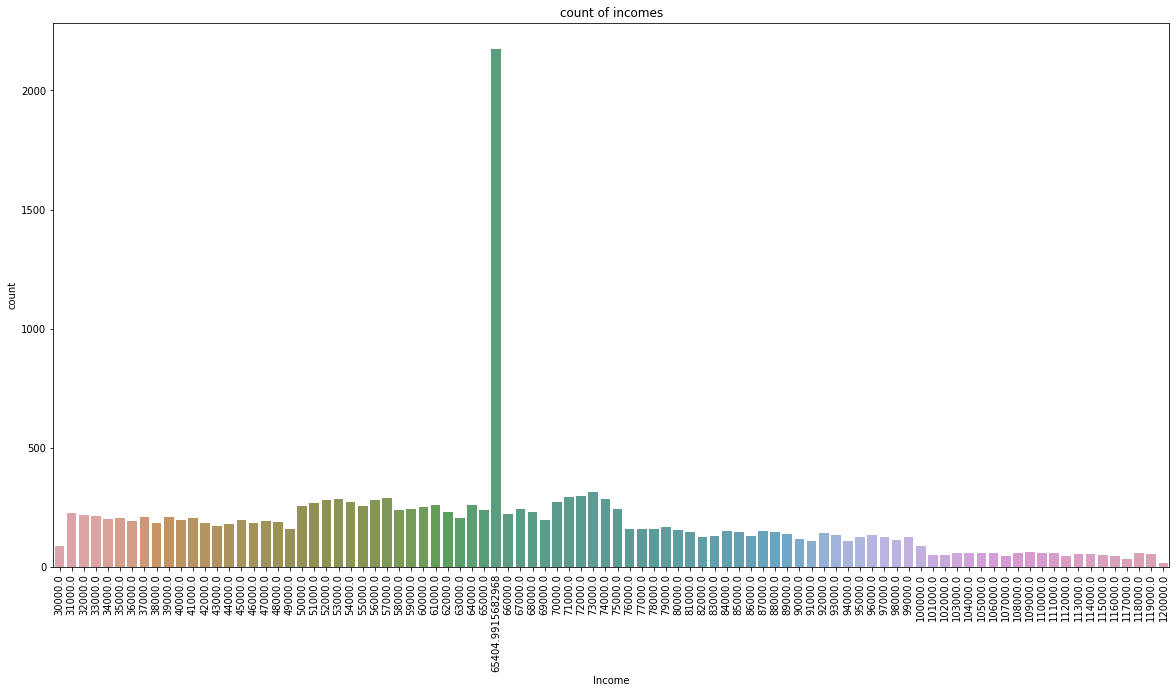

In [25]:
plt.figure(figsize=(20, 10))
sns.countplot(profile['income'], saturation=.5)
plt.title('count of incomes')
plt.ylabel('count')
plt.xlabel('Income')
plt.xticks(rotation = 90)
plt.show();

In [26]:
#getting real mean age

age_without118 = profile[profile['age']!=118]

real_mean_age = age_without118['age'].mean()
real_mean_age






54.39352445193929

In [27]:
#replacing the 118 values with real mean age 
#leaving one decimal point in order to be able to drop it later on if needed - all the other values don't have decimal points
profile['age'].replace([118], [54.4], inplace=True)

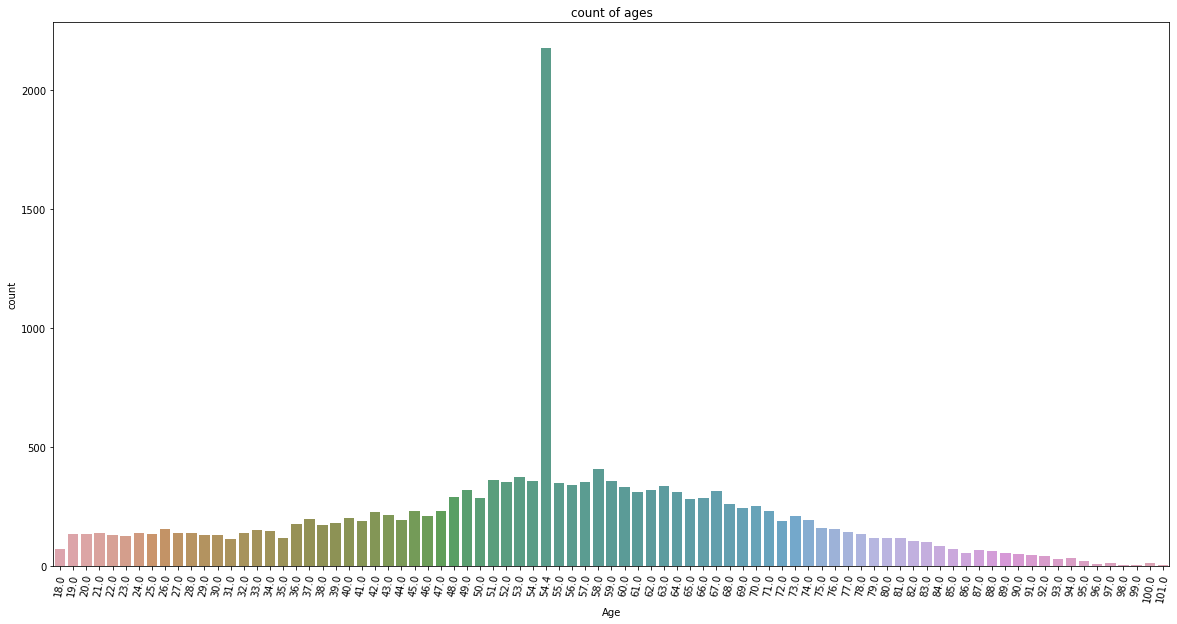

In [28]:
#checking the updated plot
plt.figure(figsize=(20, 10))
sns.countplot(profile['age'], saturation=.5)
plt.title('count of ages')
plt.ylabel('count')
plt.xlabel('Age')
plt.xticks(rotation = 80)
plt.show();


In [29]:
#dealing with the transcript dataset.
#we've seen earlier that the 'value' column would require some cleaning up. 
#let's take a closer look at the keys appearing in this column
trans_value_keys = []
for idx, row in transcript.iterrows():
    for key in row['value']:
        if key in trans_value_keys:
            continue
        else:
            trans_value_keys.append(key)

trans_value_keys

['offer id', 'amount', 'offer_id', 'reward']

In [30]:
#let's encode the keys and the offer id from this column into new columns
transcript = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
for i in ["amount", "reward"]:
    transcript[i] = transcript.value.apply(lambda x: x[i] if i in x else 0)

In [31]:
transcript.sample(10)

,person,event,value,time,offer_id,amount,reward
306348,087d0fcdbf294f7494a96d8d6a56cf41,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,714,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5
223927,4bac622e595b441cab3875bc868c28f7,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,516,2906b810c7d4411798c6938adc9daaa5,0,2
164790,ef3fdae7ff3c4b5f974ec6e76d9db036,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},408,fafdcd668e3743c1bb461111dcafc2a4,0,0
80170,0ef5270c4e634eccbfcf23a172921a8d,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,198,fafdcd668e3743c1bb461111dcafc2a4,0,2
17604,edcddc3f57f34f09a049559d2606cf6b,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},6,ae264e3637204a6fb9bb56bc8210ddfd,0,0
255059,b8baee8a55b24b2b9d91b854b1d079f9,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
59082,23fe1476e9154136b5b55eed413743a6,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0
127813,7048354f736544c99137de27a7cd0450,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},342,fafdcd668e3743c1bb461111dcafc2a4,0,0
126030,d955f6f0bfa5431fa8072c8dd77b46a9,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},336,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0
12917,2e868c31f1bf4085a44b868a75ddda77,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0


In [32]:
#it looks okay, we can now drop the original 'values' column
transcript = transcript.drop('value', axis=1)


In [33]:
#now we can finally merge the dataframes. First, I thought I could merge portfolio and profile on 'id' 
#- but it seems that 'id' in 'portfolio' stands for the offer id so the following would give us an empty dataframe:
#profile_portfolio_merged =  portfolio.merge(profile, on='id', how='inner')
#profile_portfolio_merged.head()
#instead, we need to use the transcript df as a bridge
df_prof_tran = profile.merge(transcript , left_on='id' , right_on='person' , how='inner')
print(df_prof_tran)
df_all = df_prof_tran.merge(portfolio , left_on='offer_id' , right_on = 'id' , how='inner')
print(df_all)

       gender   age                                id        income  \
0         N/A  54.4  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
1         N/A  54.4  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
2         N/A  54.4  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
3         N/A  54.4  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
4         N/A  54.4  68be06ca386d4c31939f3a4f0e3dd783  65404.991568   
...       ...   ...                               ...           ...   
167576      F  62.0  e4052622e5ba45a8b96b59aba68cf068  82000.000000   
167577      F  62.0  e4052622e5ba45a8b96b59aba68cf068  82000.000000   
167578      F  62.0  e4052622e5ba45a8b96b59aba68cf068  82000.000000   
167579      F  62.0  e4052622e5ba45a8b96b59aba68cf068  82000.000000   
167580      F  62.0  e4052622e5ba45a8b96b59aba68cf068  82000.000000   

        became_member_year  became_member_month  \
0                     2017                    2   
1                     2017                   

In [34]:
#Let's drop the duplicated columns
print(df_all.columns)
df_all.sample(10)

Index(['gender', 'age', 'id_x', 'income', 'became_member_year',
       'became_member_month', 'person', 'event', 'time', 'offer_id', 'amount',
       'reward_x', 'reward_y', 'channels', 'difficulty', 'duration',
       'offer_type', 'id_y', 'email', 'web', 'social', 'mobile'],
      dtype='object')


,gender,age,id_x,income,became_member_year,became_member_month,person,event,time,offer_id,...,reward_y,channels,difficulty,duration,offer_type,id_y,email,web,social,mobile
88723,M,62.0,2bc8d01ed07943b9ad06b426dcf73a71,80000.000000,2018,1,2bc8d01ed07943b9ad06b426dcf73a71,offer received,0,3f207df678b143eea3cee63160fa8bed,...,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
64594,F,49.0,148756e9c5ef42219e3e8acf7c35d608,100000.000000,2017,3,148756e9c5ef42219e3e8acf7c35d608,offer viewed,594,2298d6c36e964ae4a3e7e9706d1fb8c2,...,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
128330,M,50.0,638940b23fa540c69cbe92c000b0ff70,68000.000000,2018,7,638940b23fa540c69cbe92c000b0ff70,offer received,504,ae264e3637204a6fb9bb56bc8210ddfd,...,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
94131,M,51.0,5f511d72e7dc4f1990b05d298d43e8d0,54000.000000,2017,8,5f511d72e7dc4f1990b05d298d43e8d0,offer received,168,3f207df678b143eea3cee63160fa8bed,...,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
100771,N/A,54.4,dbdb5eb514cb4b94a49be1e888ef7250,65404.991568,2017,8,dbdb5eb514cb4b94a49be1e888ef7250,offer viewed,168,5a8bc65990b245e5a138643cd4eb9837,...,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,0,1,1
113119,N/A,54.4,b93ca45ff1c14f5cacad3c011e1e7fe3,65404.991568,2015,9,b93ca45ff1c14f5cacad3c011e1e7fe3,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,...,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1
64301,F,36.0,4429b18a9761470d921cb74bba65470e,91000.000000,2017,12,4429b18a9761470d921cb74bba65470e,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,...,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
10716,F,66.0,5e22919da66445a08049240dff0c3aee,114000.000000,2016,1,5e22919da66445a08049240dff0c3aee,offer completed,90,2906b810c7d4411798c6938adc9daaa5,...,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1
145112,M,51.0,b970d698e4e9401499f576ff968b8c7d,73000.000000,2017,8,b970d698e4e9401499f576ff968b8c7d,offer viewed,372,f19421c1d4aa40978ebb69ca19b0e20d,...,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
73955,F,59.0,ea1564ae2fe34244b13f1dd5903b6af4,76000.000000,2016,12,ea1564ae2fe34244b13f1dd5903b6af4,offer completed,60,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1


In [35]:
df_all.drop(['id_x' , 'id_y'], axis=1, inplace=True)
df_all.head()

,gender,age,income,became_member_year,became_member_month,person,event,time,offer_id,amount,reward_x,reward_y,channels,difficulty,duration,offer_type,email,web,social,mobile
0,N/A,54.4,65404.991568,2017,2,68be06ca386d4c31939f3a4f0e3dd783,offer received,168,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1
1,N/A,54.4,65404.991568,2017,2,68be06ca386d4c31939f3a4f0e3dd783,offer viewed,216,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1
2,M,68.0,70000.000000,2018,4,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1
3,M,68.0,70000.000000,2018,4,e2127556f4f64592b11af22de27a7932,offer viewed,18,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1
4,N/A,54.4,65404.991568,2017,9,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,408,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1


In [36]:
df_all.sample(10)

,gender,age,income,became_member_year,became_member_month,person,event,time,offer_id,amount,reward_x,reward_y,channels,difficulty,duration,offer_type,email,web,social,mobile
66464,F,52.0,68000.000000,2018,4,dd8999a8852e4bdcb0a07a924c8fa173,offer received,504,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,3,"[web, email, mobile, social]",7,7,discount,1,1,1,1
161348,F,89.0,99000.000000,2016,7,6a9fc468f1b344e4bed4893777bcd6a4,offer viewed,426,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10,"[web, email, mobile, social]",10,5,bogo,1,1,1,1
599,M,70.0,35000.000000,2018,3,825af41b833a4bcfb41a5a11005dbb48,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1
10567,N/A,54.4,65404.991568,2018,6,75f463e0323742038b0c7e67612cd133,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1
26118,M,61.0,37000.000000,2018,2,6e63df67194c449d8e5aacebc45db63c,offer received,168,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,5,"[web, email]",20,10,discount,1,1,0,0
76896,M,37.0,32000.000000,2017,10,106ebd92bff94148b4948f52079e87dc,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1
146276,F,40.0,55000.000000,2016,12,e3ad766338c84df1b24162d83ab974c1,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,0,0,5,"[web, email, mobile, social]",5,5,bogo,1,1,1,1
136706,F,94.0,86000.000000,2016,12,97412a543c2c4ff9948a92cfd90688f8,offer completed,666,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,"[web, email, mobile, social]",5,5,bogo,1,1,1,1
113574,N/A,54.4,65404.991568,2017,8,b30b3c2959494bed9f12faf317975380,offer received,336,ae264e3637204a6fb9bb56bc8210ddfd,0,0,10,"[email, mobile, social]",10,7,bogo,1,0,1,1
72877,M,76.0,80000.000000,2017,3,e4d203bf298b4859b65d2ae56714f554,offer completed,516,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5,"[web, email, mobile]",5,7,bogo,1,1,0,1


In [37]:
#it looks like the reward_x column was the actual reward that the customer received, and the reward_y column was the possible reward
df_all.rename(columns={"reward_x":"rewarded" , 'reward_y':'possible_reward' , 'value':'channels'}, inplace =True)

In [38]:
df_all.sample(10)

,gender,age,income,became_member_year,became_member_month,person,event,time,offer_id,amount,rewarded,possible_reward,channels,difficulty,duration,offer_type,email,web,social,mobile
3451,M,49.0,72000.000000,2018,5,56a30c95a6cf4950b5dcade44b0b5dac,offer viewed,0,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1
36476,M,30.0,31000.000000,2017,10,17fc3f18cb5e4b1cbebe921a69c95c05,offer viewed,504,fafdcd668e3743c1bb461111dcafc2a4,0,0,2,"[web, email, mobile, social]",10,10,discount,1,1,1,1
72251,M,31.0,60000.000000,2017,11,fc0fc865ff004b778464fbcc36fb0fc6,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1
37987,F,41.0,70000.000000,2017,12,508c159f58ac47dcab09cc3b522b2559,offer received,168,fafdcd668e3743c1bb461111dcafc2a4,0,0,2,"[web, email, mobile, social]",10,10,discount,1,1,1,1
115279,N/A,54.4,65404.991568,2016,8,8adef45dbe5c4a3da4e351045e86be3d,offer received,336,ae264e3637204a6fb9bb56bc8210ddfd,0,0,10,"[email, mobile, social]",10,7,bogo,1,0,1,1
107471,N/A,54.4,65404.991568,2014,4,c4346e97f0a74f34aba9392856e6c1e1,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0,0,0,"[email, mobile, social]",0,3,informational,1,0,1,1
12506,M,28.0,66000.000000,2018,7,691cbd0619b740f1b94f78f8bffe5abd,offer received,576,2906b810c7d4411798c6938adc9daaa5,0,0,2,"[web, email, mobile]",10,7,discount,1,1,0,1
126216,F,65.0,87000.000000,2016,2,176fd16693b9474fbf857090caf80d32,offer completed,192,ae264e3637204a6fb9bb56bc8210ddfd,0,10,10,"[email, mobile, social]",10,7,bogo,1,0,1,1
150825,N/A,54.4,65404.991568,2018,4,eb3ada86b4e3441b94d53427aa0d9eed,offer received,408,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10,"[web, email, mobile, social]",10,5,bogo,1,1,1,1
5314,M,57.0,49000.000000,2018,4,6985f8323a844af198c08899683ee172,offer completed,138,2906b810c7d4411798c6938adc9daaa5,0,2,2,"[web, email, mobile]",10,7,discount,1,1,0,1


In [39]:
#we already know that in the original profile table, 
#some rows contained NaN values in gender, age (masked as 118) and income columns
#let's now check values from other tables in the rows with said NaNs. After doing so, 
#we will be able to determine whether or not those rows are usefull to us or can we drop them
Nan_df = df_all.loc[df_all['gender']=='N/A']
Nan_df.sample(10)


,gender,age,income,became_member_year,became_member_month,person,event,time,offer_id,amount,rewarded,possible_reward,channels,difficulty,duration,offer_type,email,web,social,mobile
162010,N/A,54.4,65404.991568,2017,11,0a8446aecfe548388a774ab52162850e,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10,"[web, email, mobile, social]",10,5,bogo,1,1,1,1
118234,N/A,54.4,65404.991568,2017,12,7b30262eef3d4ea69aa84fa09aee70ed,offer viewed,336,ae264e3637204a6fb9bb56bc8210ddfd,0,0,10,"[email, mobile, social]",10,7,bogo,1,0,1,1
96660,N/A,54.4,65404.991568,2016,11,c20df4c48430421fb2b738cce8ae8f71,offer received,0,3f207df678b143eea3cee63160fa8bed,0,0,0,"[web, email, mobile]",0,4,informational,1,1,0,1
85423,N/A,54.4,65404.991568,2018,1,f3fce93462d449049a4b8615af3f5355,offer viewed,690,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1
39222,N/A,54.4,65404.991568,2017,10,cc9cc688903c431e8fa18db43ea4cb3b,offer viewed,342,fafdcd668e3743c1bb461111dcafc2a4,0,0,2,"[web, email, mobile, social]",10,10,discount,1,1,1,1
114500,N/A,54.4,65404.991568,2017,8,8f603ca13a9740dd9d6cc553166b5a2b,offer viewed,408,ae264e3637204a6fb9bb56bc8210ddfd,0,0,10,"[email, mobile, social]",10,7,bogo,1,0,1,1
54442,N/A,54.4,65404.991568,2016,2,d25c574922054a82b1bcab0a0ea3cca2,offer received,576,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,3,"[web, email, mobile, social]",7,7,discount,1,1,1,1
52974,N/A,54.4,65404.991568,2017,1,1f95b63330504bcca452f946a265461e,offer completed,426,2298d6c36e964ae4a3e7e9706d1fb8c2,0,3,3,"[web, email, mobile, social]",7,7,discount,1,1,1,1
153210,N/A,54.4,65404.991568,2018,6,f04c9064ecfe4852991fc510428c7e5b,offer viewed,186,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10,"[web, email, mobile, social]",10,5,bogo,1,1,1,1
101475,N/A,54.4,65404.991568,2016,3,c33c236fec0c4a3ba91389f33c7b7547,offer viewed,576,5a8bc65990b245e5a138643cd4eb9837,0,0,0,"[email, mobile, social]",0,3,informational,1,0,1,1


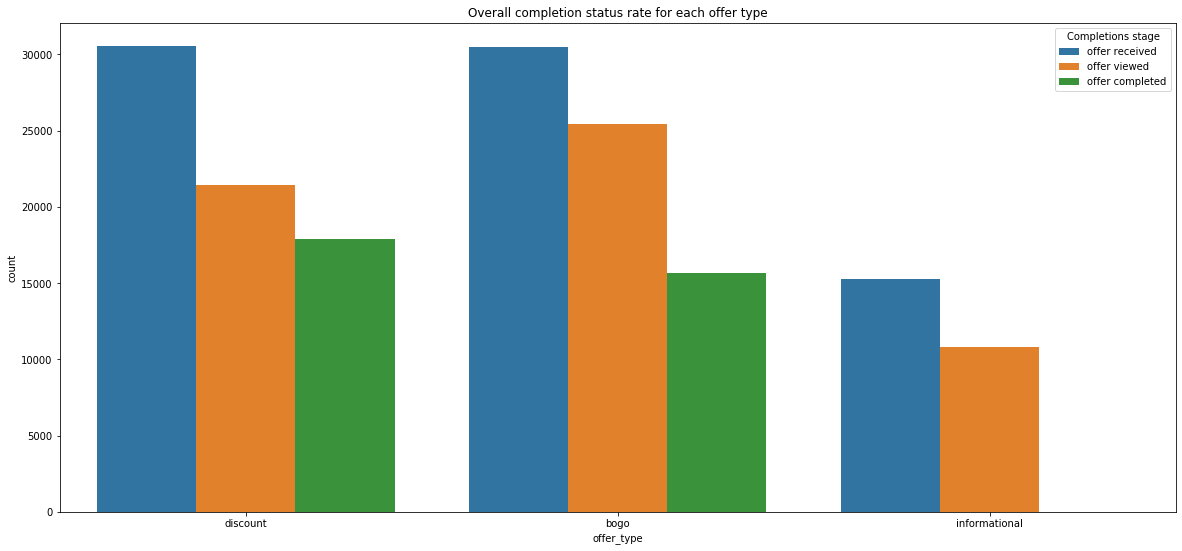

In [40]:
#As we can see in the sample, some of the crucial values (i.e. in the 'event' column) are not  always the same in these rows. 
#However, the lack of personal information about those users makes them useful only for the purpose 
#of analyzing the offers by themselves, without taking into account the users profile
#Let's start with that analysis and we'll drop these rows later on.

plt.figure(figsize=(20, 9))
sns.countplot(x=df_all.offer_type, hue='event', data=df_all)
plt.title('Overall completion status rate for each offer type')
plt.ylabel('count')
plt.xlabel('offer_type')
plt.legend(title='Completions stage')
plt.show();



In [41]:
#we can now drop informational offer type, it won't be useful for the next couple of plots
df_non_info = df_all[df_all['offer_type']=='informational'].index
df_non_info = df_all.drop(df_non_info)
df_non_info.sample(10)

,gender,age,income,became_member_year,became_member_month,person,event,time,offer_id,amount,rewarded,possible_reward,channels,difficulty,duration,offer_type,email,web,social,mobile
140703,F,84.0,83000.000000,2016,5,56c0519eb78d404e8648e0b634648b77,offer completed,600,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,"[web, email, mobile, social]",5,5,bogo,1,1,1,1
77270,M,57.0,83000.000000,2018,6,a2633655a62e4287a3b651d926a774a6,offer completed,192,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,5,"[web, email, mobile]",5,7,bogo,1,1,0,1
133990,M,48.0,51000.000000,2018,4,f01b2d37aeb24bd981c3188ddbd4e659,offer completed,450,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,"[web, email, mobile, social]",5,5,bogo,1,1,1,1
85528,F,55.0,53000.000000,2015,9,c9b534cdac834e5d9853828816300e57,offer received,336,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,5,"[web, email, mobile]",5,7,bogo,1,1,0,1
165470,F,21.0,74000.000000,2016,11,0335d274249f4eb6b3c51527f02a3216,offer viewed,174,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,10,"[web, email, mobile, social]",10,5,bogo,1,1,1,1
53095,N/A,54.4,65404.991568,2017,9,ed851c7728e34d21854a3ece16c3417a,offer viewed,510,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,3,"[web, email, mobile, social]",7,7,discount,1,1,1,1
62759,M,72.0,42000.000000,2018,5,ec55c53fd6f643db99b9cc390c6417b3,offer received,408,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,3,"[web, email, mobile, social]",7,7,discount,1,1,1,1
30853,F,63.0,96000.000000,2016,4,72f6338d8b124f06be857d656019e0f8,offer viewed,408,fafdcd668e3743c1bb461111dcafc2a4,0,0,2,"[web, email, mobile, social]",10,10,discount,1,1,1,1
50494,F,67.0,50000.000000,2017,7,de938b5f2be14afe96fbf02398907c2c,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,3,"[web, email, mobile, social]",7,7,discount,1,1,1,1
120203,F,57.0,93000.000000,2017,5,83d46d42789c42d3bfca525ce3ea8c17,offer received,504,ae264e3637204a6fb9bb56bc8210ddfd,0,0,10,"[email, mobile, social]",10,7,bogo,1,0,1,1


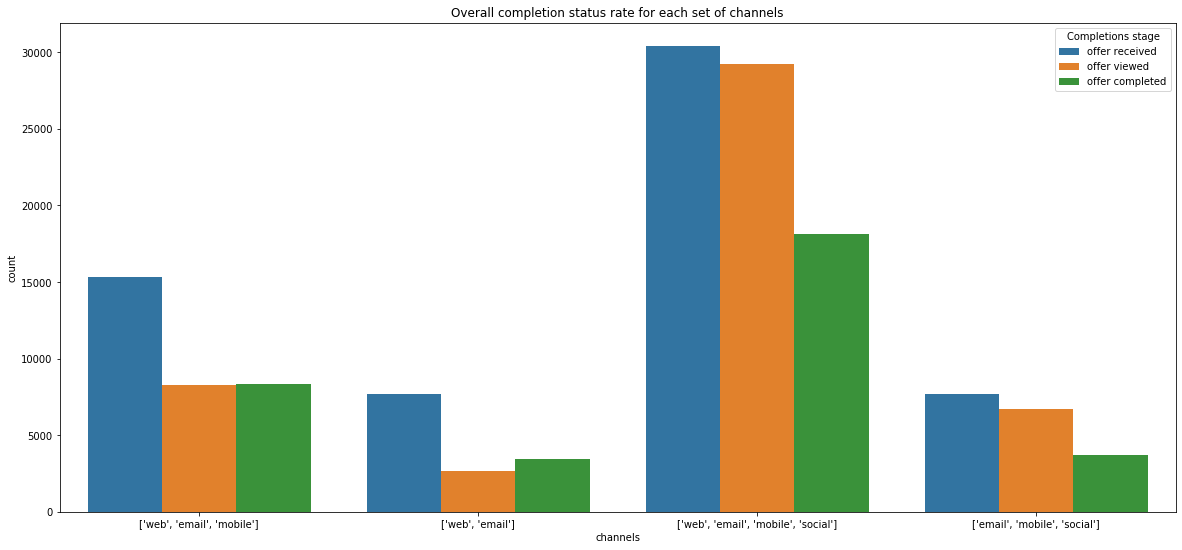

In [42]:
df_non_info['channels'] = df_non_info['channels'].astype(str)
plt.figure(figsize=(20, 9))
sns.countplot(x=df_non_info.channels, hue='event', data=df_non_info)
plt.title('Overall completion status rate for each set of channels')
plt.ylabel('count')
plt.xlabel('channels')
plt.legend(title='Completions stage')
plt.show();

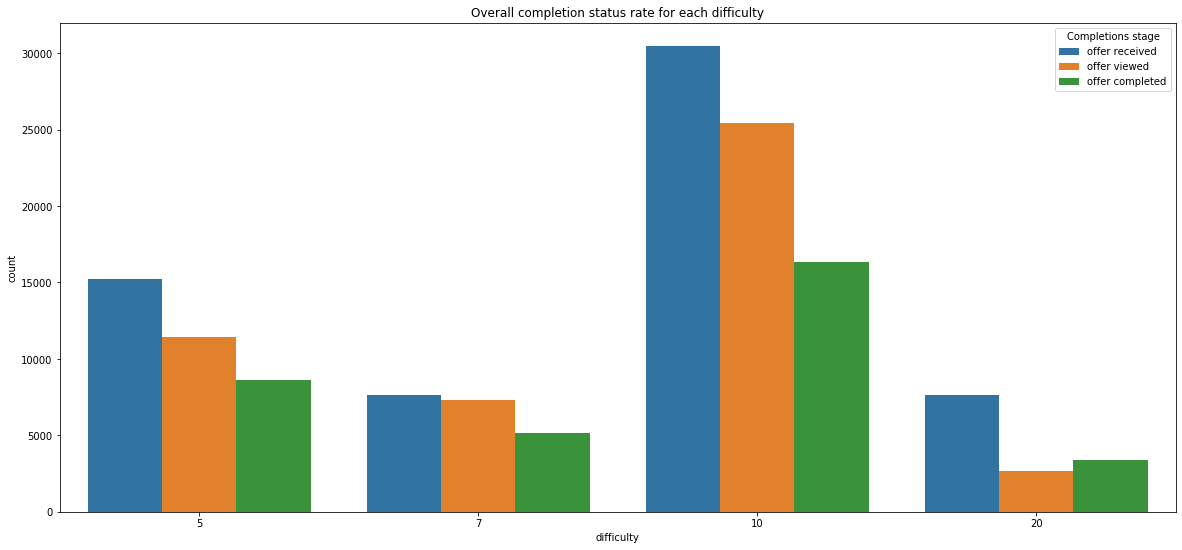

In [43]:
plt.figure(figsize=(20, 9))
sns.countplot(x=df_non_info.difficulty, hue='event', data=df_non_info)
plt.title('Overall completion status rate for each difficulty')
plt.ylabel('count')
plt.xlabel('difficulty')
plt.legend(title='Completions stage')
plt.show();

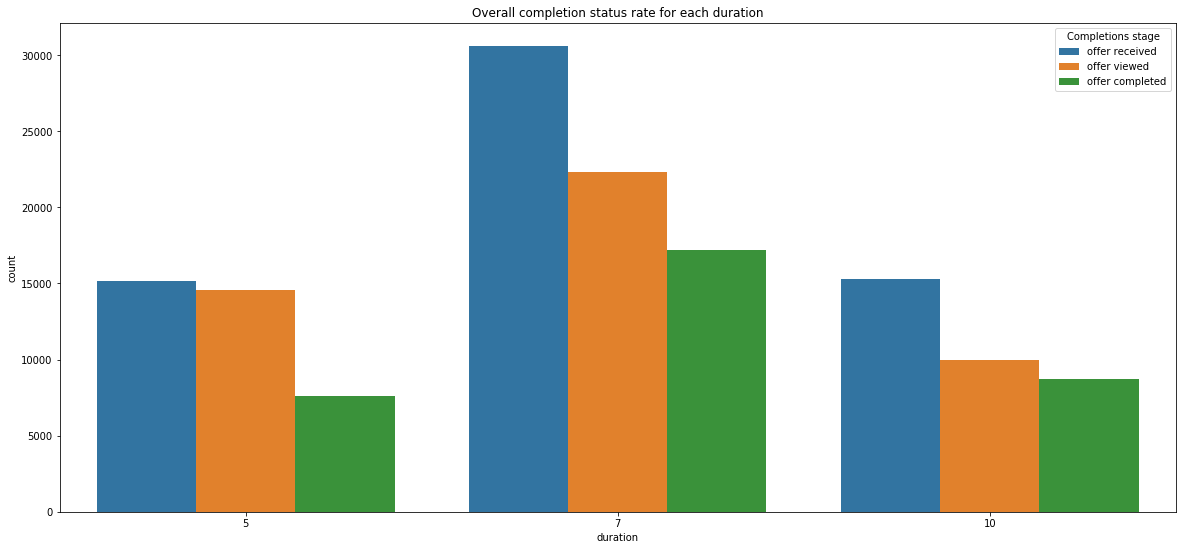

In [44]:
plt.figure(figsize=(20, 9))
sns.countplot(x=df_non_info.duration, hue='event', data=df_non_info)
plt.title('Overall completion status rate for each duration')
plt.ylabel('count')
plt.xlabel('duration')
plt.legend(title='Completions stage')
plt.show();

In [45]:
#I got what I wanted from the dataframe containing the NaNs,
#now we can finally drop the 'channels' column and all the NaN rows from the main dataframe
#I will also create new columns - age_group and income_group
df_all_cleaned = df_all.drop('channels', axis = 1, inplace=True)
df_to_clean = df_all[df_all['gender']=='N/A'].index
df_all_cleaned = df_all.drop(df_to_clean)
df_all_cleaned['age_group'] = pd.cut(df_all_cleaned['age'], bins=[11, 19, 40, 60, 118],labels=['teenager', 'adult', 'middle-aged', 'elderly'])
df_all_cleaned['income_group'] = pd.cut(df_all_cleaned['income'], bins=[0, 30000, 60000, 90000, 120000],labels=[1, 2, 3, 4])
df_all_cleaned.sample(10)

,gender,age,income,became_member_year,became_member_month,person,event,time,offer_id,amount,...,possible_reward,difficulty,duration,offer_type,email,web,social,mobile,age_group,income_group
93555,F,32.0,71000.0,2017,12,d98e24fb0e6e47309b138aeb904cbe46,offer viewed,96,3f207df678b143eea3cee63160fa8bed,0,...,0,0,4,informational,1,1,0,1,adult,3
17361,M,68.0,56000.0,2017,9,9e64ffbc7e3f413ebfb9aae9bb893c49,offer viewed,420,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,...,5,20,10,discount,1,1,0,0,elderly,2
115521,F,80.0,109000.0,2017,11,59d88f8c7bc44544b795f3c804137ec2,offer completed,186,ae264e3637204a6fb9bb56bc8210ddfd,0,...,10,10,7,bogo,1,0,1,1,elderly,4
55448,F,50.0,82000.0,2016,10,9f066310867e45639d8e2ab82948fce4,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,0,...,3,7,7,discount,1,1,1,1,middle-aged,3
83299,F,55.0,59000.0,2016,11,f8d61365a8064816917c950076174ef0,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,...,5,5,7,bogo,1,1,0,1,middle-aged,2
157240,M,57.0,79000.0,2017,5,2d073f4324f44580b5bbc2acdb9d95cf,offer completed,606,4d5c57ea9a6940dd891ad53e9dbe8da0,0,...,10,10,5,bogo,1,1,1,1,middle-aged,3
119754,F,50.0,88000.0,2017,12,9cff5cba68bb44b5baeb3d18c424297c,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,0,...,10,10,7,bogo,1,0,1,1,middle-aged,3
135467,M,55.0,50000.0,2018,1,a3320e68bc214d66abe4ac794cb850ba,offer completed,114,f19421c1d4aa40978ebb69ca19b0e20d,0,...,5,5,5,bogo,1,1,1,1,middle-aged,2
63519,F,65.0,59000.0,2013,12,1a2c6fd57fad4250b35c1b0903ed34ea,offer completed,624,2298d6c36e964ae4a3e7e9706d1fb8c2,0,...,3,7,7,discount,1,1,1,1,elderly,2
16991,M,70.0,105000.0,2017,8,8fc40f08bcc7442796802b19ffcc9e04,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,...,5,20,10,discount,1,1,0,0,elderly,4


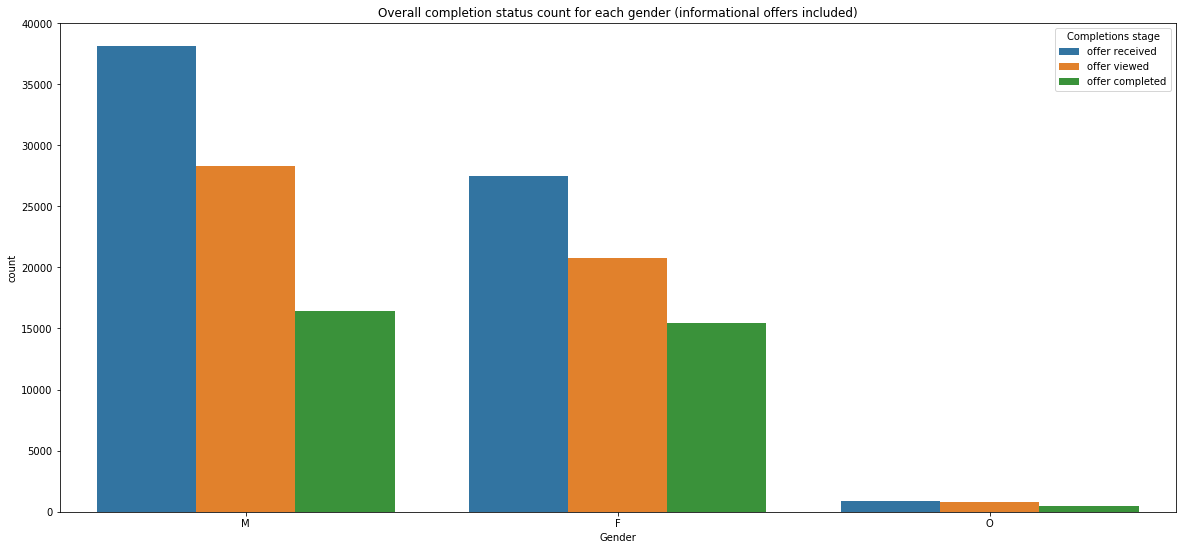

In [46]:
#let's now focus on the data from the profile table and its relation to the offer completion rate
plt.figure(figsize=(20, 9))
sns.countplot(x=df_all_cleaned.gender, hue='event', data=df_all_cleaned)
plt.title('Overall completion status count for each gender (informational offers included)')
plt.ylabel('count')
plt.xlabel('Gender')
plt.legend(title='Completions stage')
plt.show();


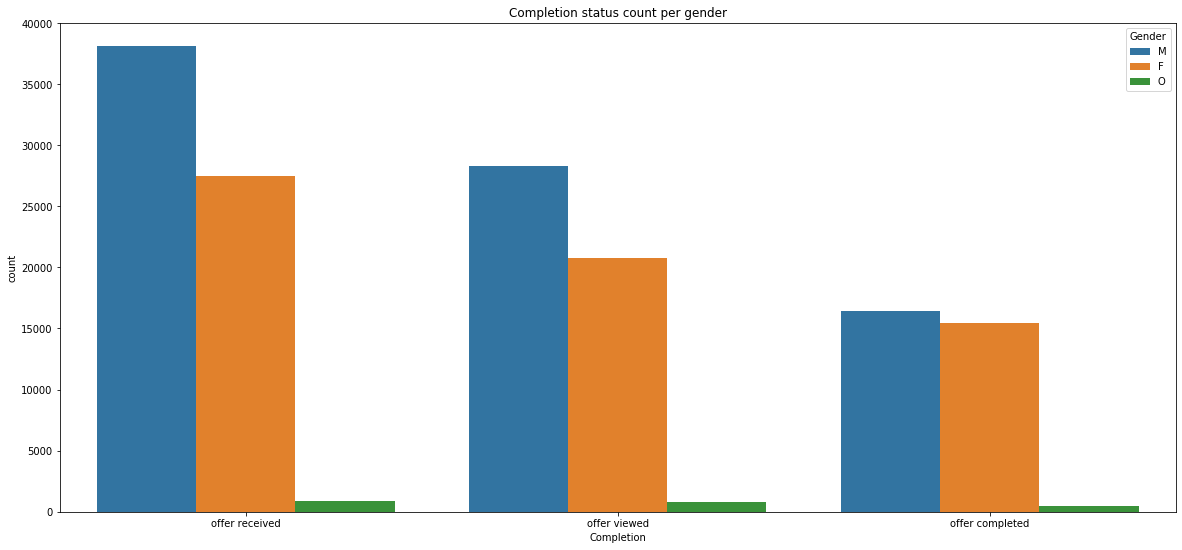

In [47]:
plt.figure(figsize=(20, 9))
sns.countplot(x=df_all_cleaned.event, hue='gender', data=df_all_cleaned)
plt.title('Completion status count per gender')
plt.ylabel('count')
plt.xlabel('Completion')
plt.legend(title='Gender')
plt.show();

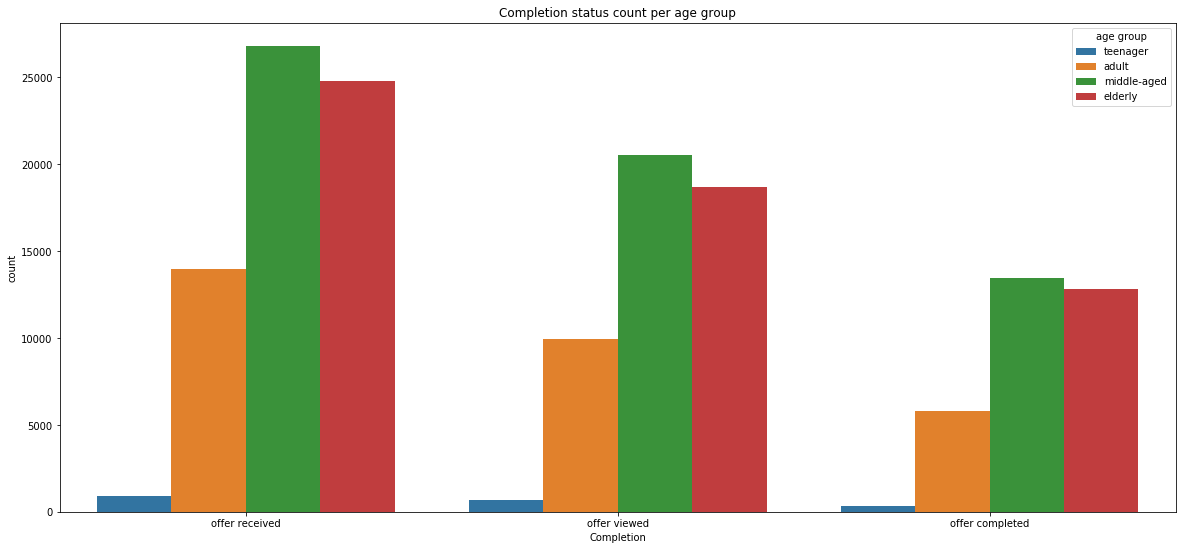

In [48]:
plt.figure(figsize=(20, 9))
sns.countplot(x=df_all_cleaned.event, hue='age_group', data=df_all_cleaned)
plt.title('Completion status count per age group')
plt.ylabel('count')
plt.xlabel('Completion')
plt.legend(title='age group')
plt.show();

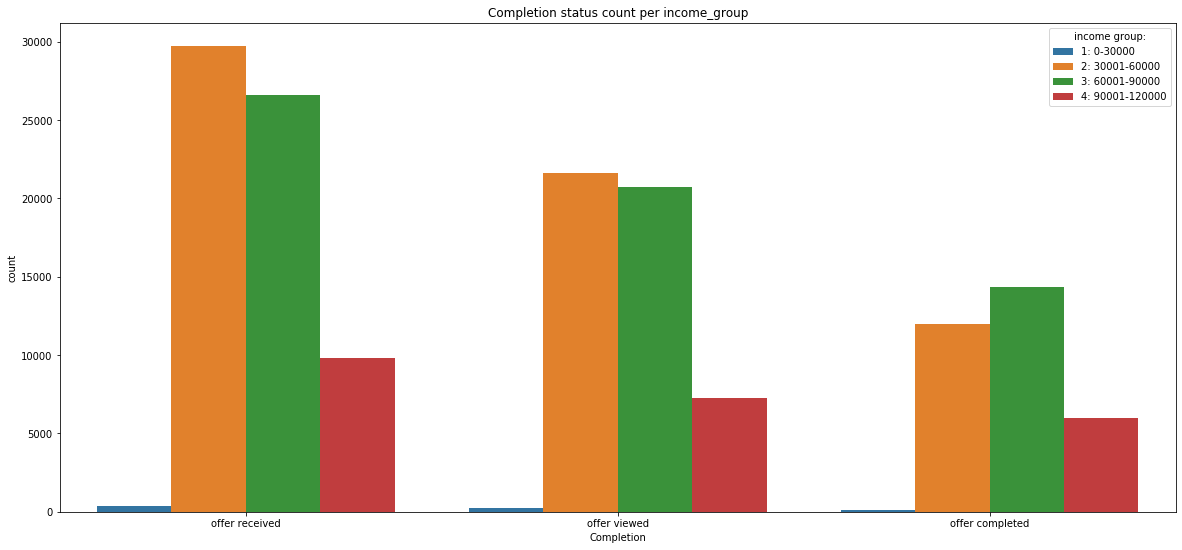

In [49]:
plt.figure(figsize=(20, 9))
sns.countplot(x=df_all_cleaned.event, hue='income_group', data=df_all_cleaned)
plt.title('Completion status count per income_group')
plt.ylabel('count')
plt.xlabel('Completion')
plt.legend(['1: 0-30000', '2: 30001-60000', '3: 60001-90000','4: 90001-120000'] , title='income group:')
plt.show();

In [50]:
#modelling part

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler



In [51]:
#getting dummies and changing categorical columns to integers
columns_to_dummies = ['event' , 'gender']
df_model = pd.get_dummies(df_all_cleaned, columns=columns_to_dummies, prefix = columns_to_dummies)
#df_model = df_all_cleaned
#df_model['event'].replace(['offer viewed','offer received','offer completed'], [1,2,3], inplace=True)
#df_model['gender'].replace(['M','F','O'], [1,2,3], inplace=True)
df_model['offer_type'].replace(['bogo','discount','informational'], [1,2,3], inplace=True)
df_model['age_group'].replace(['teenager','adult','middle-aged','elderly'], [1,2,3,4], inplace=True)
df_model.columns

Index(['age', 'income', 'became_member_year', 'became_member_month', 'person',
       'time', 'offer_id', 'amount', 'rewarded', 'possible_reward',
       'difficulty', 'duration', 'offer_type', 'email', 'web', 'social',
       'mobile', 'age_group', 'income_group', 'event_offer completed',
       'event_offer received', 'event_offer viewed', 'gender_F', 'gender_M',
       'gender_O'],
      dtype='object')

In [52]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

#features = ['time', 'amount', 'rewarded', 'duration' , 'income']

#X_scaled = X.copy()

#X_scaled[features] = scaler.fit_transform(X_scaled[features])

#X_scaled.head()

In [54]:
# Spliting to training and testing sets
#X = df_model[['time','age', 'amount', 'rewarded', 'possible_reward',
 #      'difficulty', 'duration', 'social', 'email', 'web',
  #     'mobile', 'age_group', 'income_group', 'event_offer completed', 'event_offer received',
   #    'event_offer viewed', 'gender_F', 'gender_M', 'gender_O']]
#y = df_model['offer_type']

X = df_model[['time' ,'difficulty' ,'duration' ,'email','mobile' ,'income','rewarded',
                 'social','web','age','income','became_member_year','became_member_month','event_offer completed',
                 'event_offer received' ,'event_offer viewed' ,'event_offer viewed','gender_F','gender_M','gender_O']]
y = df_model['offer_type']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train = y_train.ravel()
y_test = y_test.ravel()


In [55]:
clf_A = GaussianNB()
clf_A.fit(X_train, y_train)
y_test_preds = clf_A.predict(X_test)
print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
#print('Precision: %.3f' % precision_score(X_train, y_train))
print('Accuracy : {:.2f}'.format(clf_A.score(X_train, y_train)*100)+'%')

R2 = 0.7615
mean squared error =  0.1209
Accuracy : 87.97%


In [56]:
clf_B = DecisionTreeClassifier()
clf_B.fit(X_train, y_train)
y_test_preds = clf_B.predict(X_test)
print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
print('Accuracy : {:.2f}'.format(clf_A.score(X_train, y_train)*100)+'%')

R2 = 1.0000
mean squared error =  0.0000
Accuracy : 87.97%


In [57]:
clf_D = LinearRegression()
clf_D.fit(X_train, y_train)
y_test_preds = clf_D.predict(X_test)

print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
print('Accuracy : {:.2f}'.format(clf_A.score(X_train, y_train)*100)+'%')

R2 = 0.4219
mean squared error =  0.2930
Accuracy : 87.97%


In [58]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
print('Accuracy : {:.2f}'.format(clf_A.score(X_train, y_train)*100)+'%')

R2 = 0.4219
mean squared error =  0.2930
Accuracy : 87.97%


In [59]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
print('R2 = {:.4f}'.format(r2_score(y_test, y_test_preds)))
print('mean squared error =  {:.4f}'.format(mean_squared_error(y_test, y_test_preds)))
print('Accuracy : {:.2f}'.format(clf_A.score(X_train, y_train)*100)+'%')



R2 = 0.4219
mean squared error =  0.2930
Accuracy : 87.97%


In [ ]:
#RANO: OGARNĄĆ  ZMIENNE W MODELACH!!! ZROBIĆ GRIDSEARCH I EWALUACJĘ!!! NAPISAĆ POST I README!!!